# Stock Price Prediction Using Wavelet + LSTM - Python

#### Library needed

https://pywavelets.readthedocs.io/en/latest/install.html

In [1]:
#!pip install PyWavelets
# OR

#conda install -c conda-forge pywavelets

   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.3 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.3 MB 2.1 MB/s eta 0:00:02
   ------------------- -------------------- 2.1/4.3 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------  4.2/4.3 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 4.3/4.3 MB 5.8 MB/s eta 0:00:00


In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [3]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional,  RepeatVector,Flatten
from tensorflow.keras.callbacks import EarlyStopping

import pywt

In [4]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import statsmodels
print(f"statsmodel version: {statsmodels.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")
import sklearn 
print(f"sklearn version: {sklearn. __version__}")
print(f"TensorFlow version: {tf.__version__}")
print("Cuda Available: ", tf.test.is_built_with_cuda())

Python version: 3.10.14
numpy version: 1.26.4
panda version: 2.2.1
seaborn version: 0.13.2
matplotlib version: 3.7.5
statsmodel version: 0.14.1
scipy version: 1.14.1
sklearn version: 1.4.1.post1
TensorFlow version: 2.10.0
Cuda Available:  True


## Helper Function

In [5]:
# Helper Function to fetch historical stock data
import yfinance as yf
def get_stock_data(ticker, start_date, end_date):
    try:
        # https://medium.com/nerd-for-tech/all-you-need-to-know-about-yfinance-yahoo-finance-library-fa4c6e48f08e
        #data = yf.Ticker(ticker).history(start=start_date, end=end_date)  
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        return f"Error fetching data: {e}"

In [6]:
# code from https://goldinlocks.github.io/Multivariate-time-series-models/

from scipy.stats import probplot, moment
# Hurst Exponent
def hurst(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0
    
# Correlogram Plot
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Gather Historical Data

In [7]:
ticker_symbol = "AAPL"  #  Apple Inc. 
start_date = "2010-01-01"
end_date = "2024-10-01"
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data.asfreq('B').index  # set index frequency to business daliy
stock_data.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3710 entries, 2010-01-04 to 2024-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3710 non-null   float64
 1   High       3710 non-null   float64
 2   Low        3710 non-null   float64
 3   Close      3710 non-null   float64
 4   Adj Close  3710 non-null   float64
 5   Volume     3710 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 331.9 KB


In [8]:
stock_data.isnull().sum(axis=0) # check any NA

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
stock_data.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-09-24  228.649994  229.350006  225.729996  227.369995  227.369995   
2024-09-25  224.929993  227.289993  224.020004  226.369995  226.369995   
2024-09-26  227.300003  228.500000  225.410004  227.520004  227.520004   
2024-09-27  228.460007  229.520004  227.300003  227.789993  227.789993   
2024-09-30  230.039993  233.000000  229.649994  233.000000  233.000000   

              Volume  
Date                  
2024-09-24  43556100  
2024-09-25  42308700  
2024-09-26  36636700  
2024-09-27  34026000  
2024-09-30  54541900

## Exploratory Data Analysis (EDA)

In [10]:
import plotly.express as px

fig = px.line(stock_data, x=stock_data.index, y='Close', title=f'The Stock Close Price of {ticker_symbol}',
              labels={'Close': 'Close Price $'},
              template='plotly', width=1000, height=600)
fig.update_traces(line_color='lawngreen')
fig.update_layout(title_font_color='blue', title_font_size=20)
fig.show()

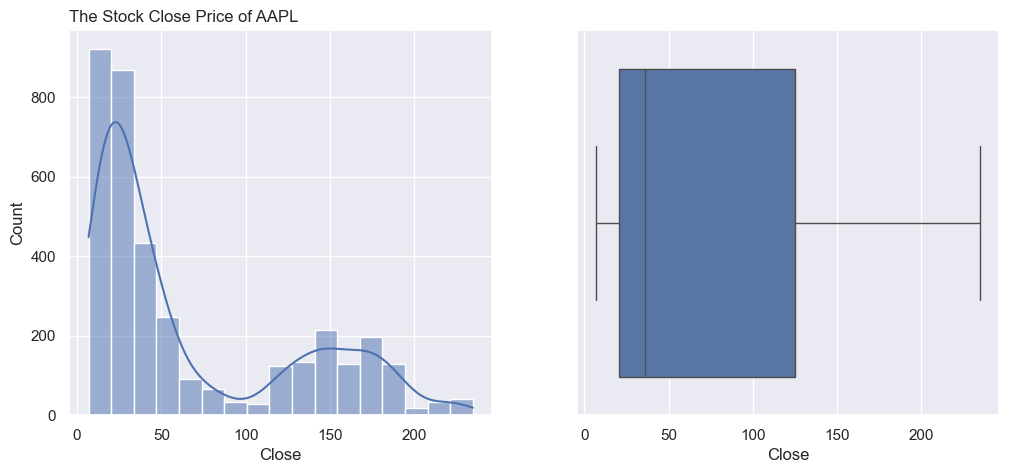

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f'The Stock Close Price of {ticker_symbol}', loc='left')
sns.histplot(stock_data['Close'], kde=True)
plt.subplot(1,2,2)
sns.boxplot(stock_data['Close'] , orient="h")
plt.show()


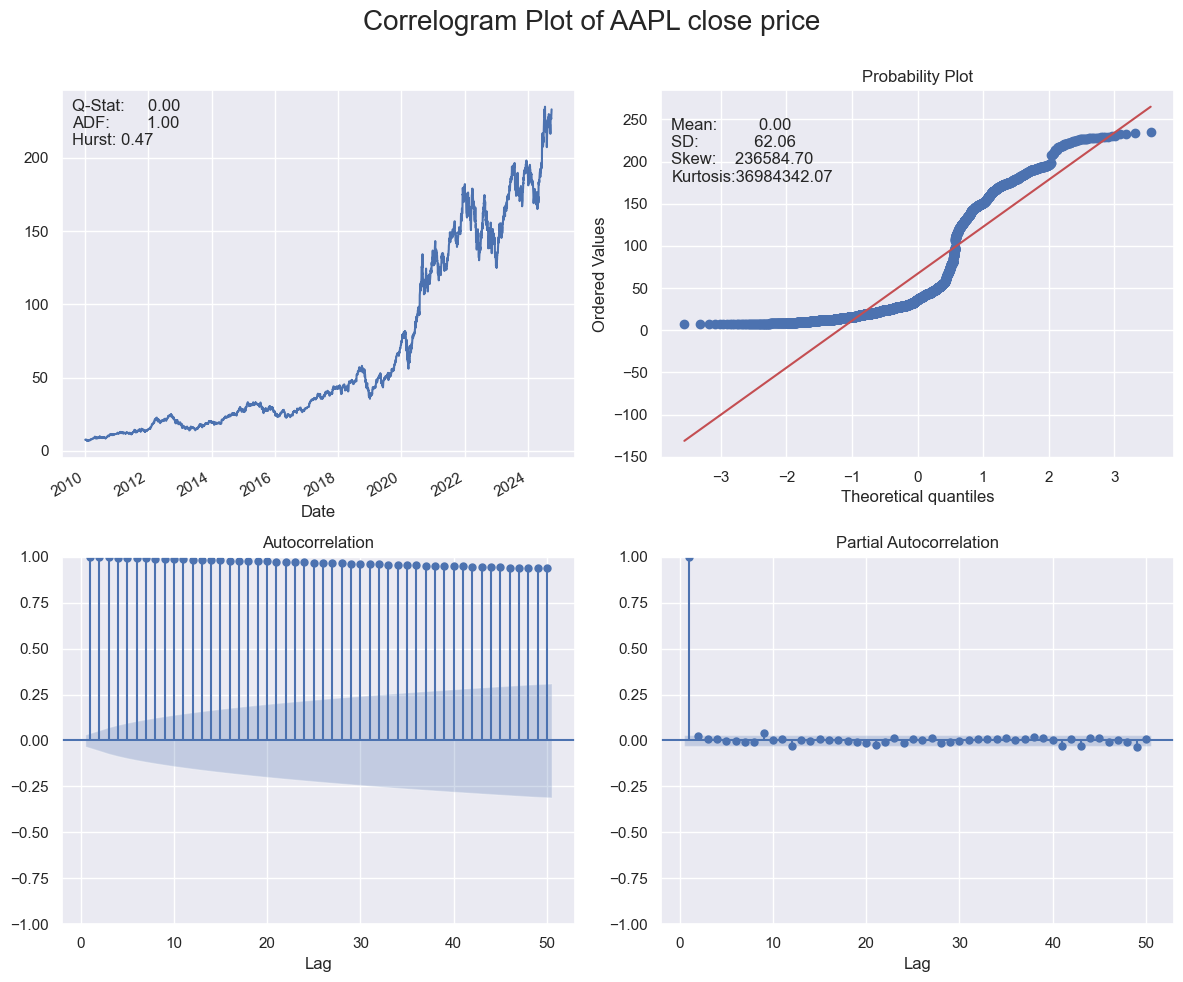

In [12]:
plot_correlogram(stock_data['Close'], lags=50, title=f'Correlogram Plot of {ticker_symbol} close price')

<Figure size 1500x1000 with 0 Axes>

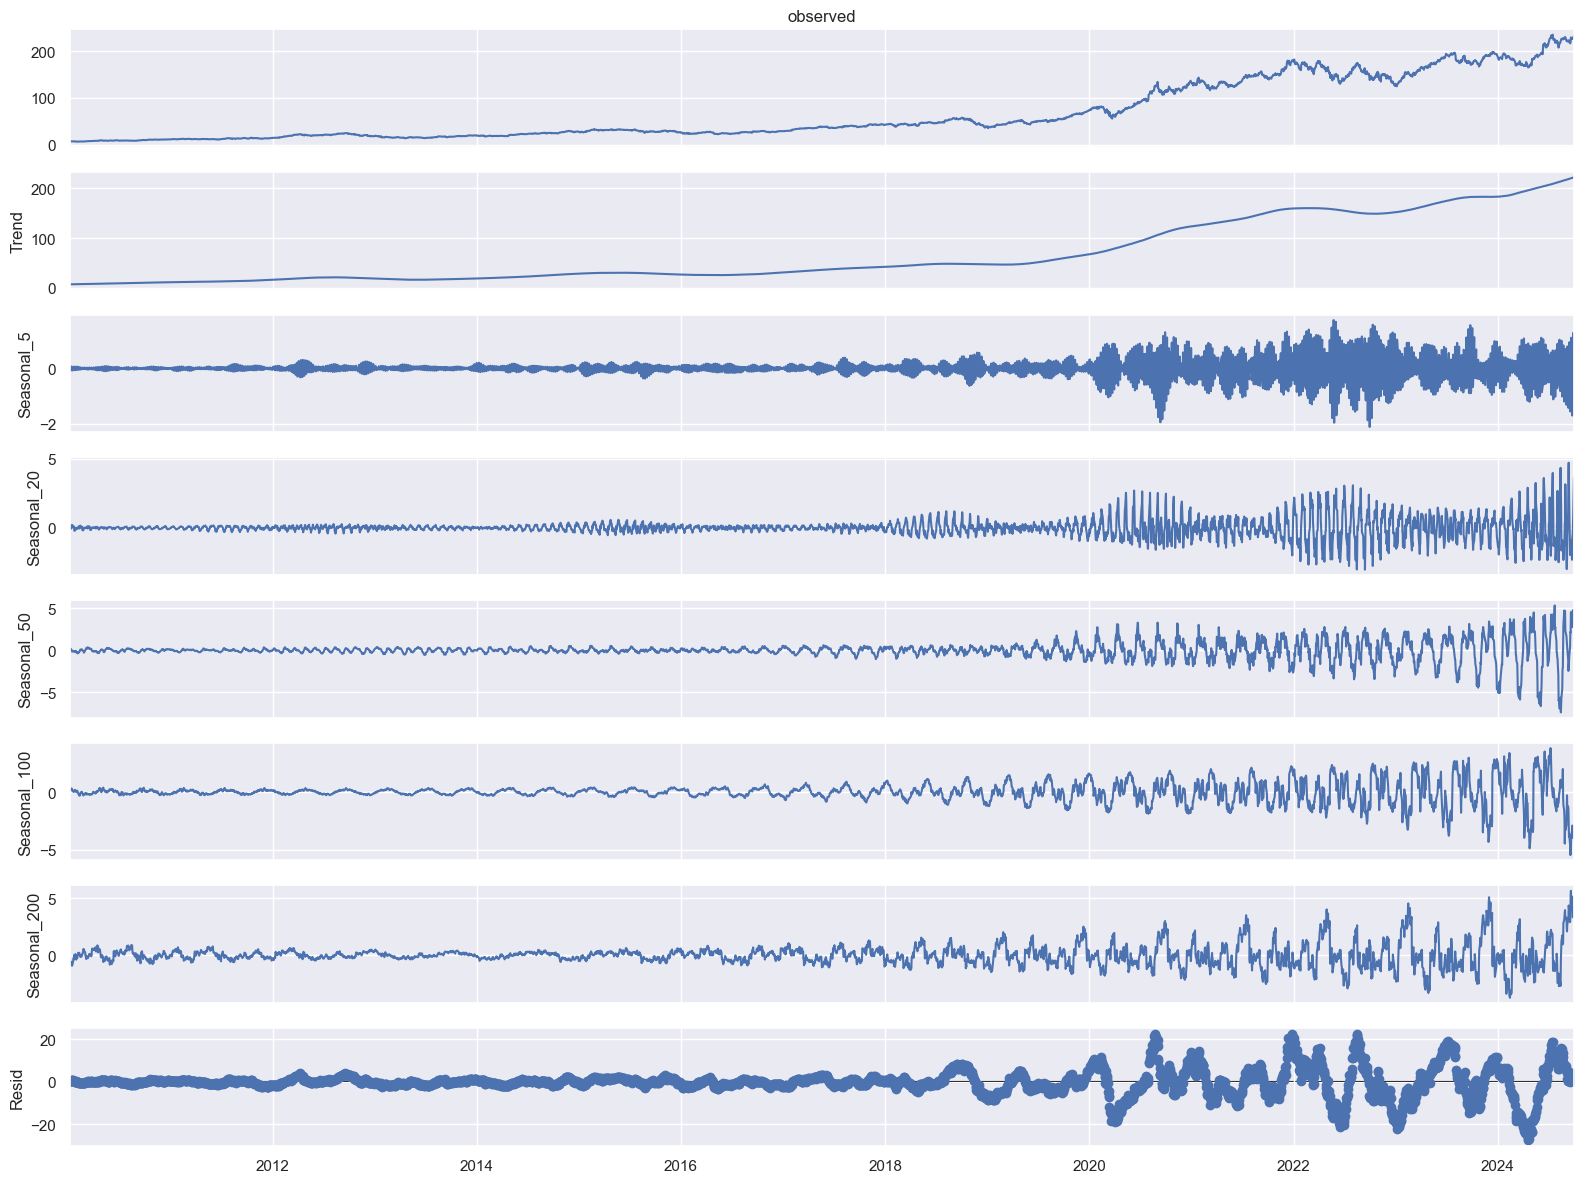

In [13]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html
# Multiple Seasonal-Trend decomposition using LOESS (MSTL); locally Estimated Ecatterplot Smoothing (LOESS)
from statsmodels.tsa.seasonal import MSTL

plt.rc("figure", figsize=(16, 12))
plt.figure(figsize=(15,10))
# decomposited by 5,20,50,100,200-days
MSTL_result = MSTL(endog=stock_data['Close'],  periods=(5, 20 ,50, 100, 200)).fit()

MSTL_result.plot()

plt.show()

# Save the figure
#plt.savefig('MSTL.jpg')

## Test for Normality

In [14]:
# code from https://dataaspirant.com/jarque-bera-test/

from scipy.stats import jarque_bera

# calculate the test statistic and p-value
jb_stat, jb_p = jarque_bera(stock_data['Close'])

# print the results
print("Jarque-Bera statistic:", jb_stat)
print("p-value:", jb_p)

# interpret the results
if jb_p < 0.05:
    print("The dataset is not normally distributed.")
else:
    print("The dataset is normally distributed.")

Jarque-Bera statistic: 645.4742009330482
p-value: 6.871604603054043e-141
The dataset is not normally distributed.


## Test for Autocorrelation

In [15]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox

def ljung_box_test_original(data, lags_list=[5, 10]):
    # Perform the Ljung-Box test for both lag=5 and lag=10
    for lag in lags_list:
        lb_test = acorr_ljungbox(data, lags=lags_list, return_df=True)

        # Extract p-value
        p_value = lb_test['lb_pvalue'].iloc[0]

        # Interpret the result
        if p_value > 0.05:
            interpretation = f"Fail to reject the null hypothesis at lag {lag}: No significant autocorrelation."
        else:
            interpretation = f"Reject the null hypothesis at lag {lag}: Significant autocorrelation present."

        print(f"Ljung-Box test p-value for lag {lag}: {p_value:.5f}")
        print(f"Interpretation: {interpretation}")
        print

ljung_box_test_original(stock_data['Close'])


Ljung-Box test p-value for lag 5: 0.00000
Interpretation: Reject the null hypothesis at lag 5: Significant autocorrelation present.
Ljung-Box test p-value for lag 10: 0.00000
Interpretation: Reject the null hypothesis at lag 10: Significant autocorrelation present.


### When the Ljung-Box test indicates significant autocorrelation, it means that the data points in the series are not randomly distributed. Instead, past values significantly influence future values, suggesting a pattern or trend in the data.

In [16]:
# Check any autocorrelation present in MSTL residual

ljung_box_test_original(MSTL_result.resid, [10, 15])

Ljung-Box test p-value for lag 10: 0.00000
Interpretation: Reject the null hypothesis at lag 10: Significant autocorrelation present.
Ljung-Box test p-value for lag 15: 0.00000
Interpretation: Reject the null hypothesis at lag 15: Significant autocorrelation present.


## Test for Stationarity

In [17]:
# Augmented Dickey–Fuller test for stationarity
result = adfuller(stock_data['Close'],regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: -3.534705
p-value: 0.104391
Critical Values:
	1%: -4.374
	5%: -3.834
	10%: -3.554
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


### If a time series is non-stationary but shows significant autocorrelation, it indicates that while the data has trends or varying means over time (non-stationarity), there are also patterns where past values are influencing future values (autocorrelation).

### Non-stationary data often means that mean, variance, or other statistical properties change over time. This can result from trends, seasonality, or structural changes in the data. Autocorrelation in this context suggests these patterns are not purely random but have predictable influences over time.

## Test for Nonlinearity 

In [18]:
# Brock-Dechert-Scheinkman (BDS) test,

import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat

# Function to perform the BDS test
def bds_test(data, max_dim=10):
    results = []
    for m in range(2, max_dim + 1):
        transformed_data = lagmat(data, m, trim='both')
        residuals = np.diff(transformed_data, axis=1)
        test_result = sm.tsa.stattools.bds(residuals[:, -1])
        results.append(test_result)
    return results

# Print function for BDS test results
def print_bds_results(results):
    for i, result in enumerate(results):
        m = i + 2
        test_statistic, p_value, *_ = result
        print(f"Dimension m = {m}:")
        print(f"  Test Statistic: {test_statistic:.4f}")
        print(f"  p-value: {p_value:.4f}")
        if p_value < 0.05:
            print("  Result: Reject the null hypothesis (Nonlinear dependencies detected)")
        else:
            print("  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)")
        print("")

# Perform BDS test
bds_results = bds_test(stock_data['Close'])

# Print BDS test results
print_bds_results(bds_results)

Dimension m = 2:
  Test Statistic: 1.9314
  p-value: 0.0534
  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)

Dimension m = 3:
  Test Statistic: 1.9288
  p-value: 0.0538
  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)

Dimension m = 4:
  Test Statistic: 1.9272
  p-value: 0.0540
  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)

Dimension m = 5:
  Test Statistic: 1.9250
  p-value: 0.0542
  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)

Dimension m = 6:
  Test Statistic: 1.9249
  p-value: 0.0542
  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)

Dimension m = 7:
  Test Statistic: 1.9216
  p-value: 0.0547
  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)

Dimension m = 8:
  Test Statistic: 1.9410
  p-value: 0.0523
  Result: Fail to reject the null hypothesis (Likely linear or i.i.d.)

Dimension m = 9:
  Test Statistic: 1.9324
  p-value: 0.0533
  Result: Fail t

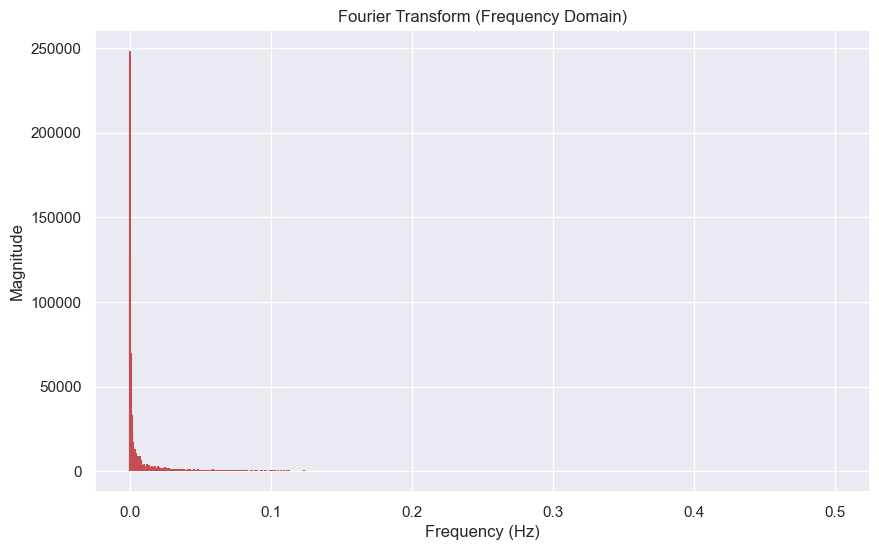

In [22]:
# Check seasonal cycle using Spectral Analysis (Fourier Transform)

freqs = np.fft.fftfreq(len(stock_data['Close']))
magn =  np.abs(np.fft.fft(stock_data['Close']))
plt.figure(figsize=(10, 6))
plt.stem(freqs[:len(freqs)//2], 
           magn[:len(magn)//2], 
           linefmt='r', markerfmt=" ", basefmt=" ")


plt.title("Fourier Transform (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
#plt.show()

# Save the figure
plt.savefig('fft.jpg')

In [44]:
def recommend_levels(signal_length):
    """
    Recommend maximum decomposition level
    """
    return pywt.dwt_max_level(signal_length, 'db6')

# Example
signal_length = len(stock_data['Close'])
max_level = recommend_levels(signal_length)
print(f"Recommended maximum level: {max_level}")

Recommended maximum level: 8


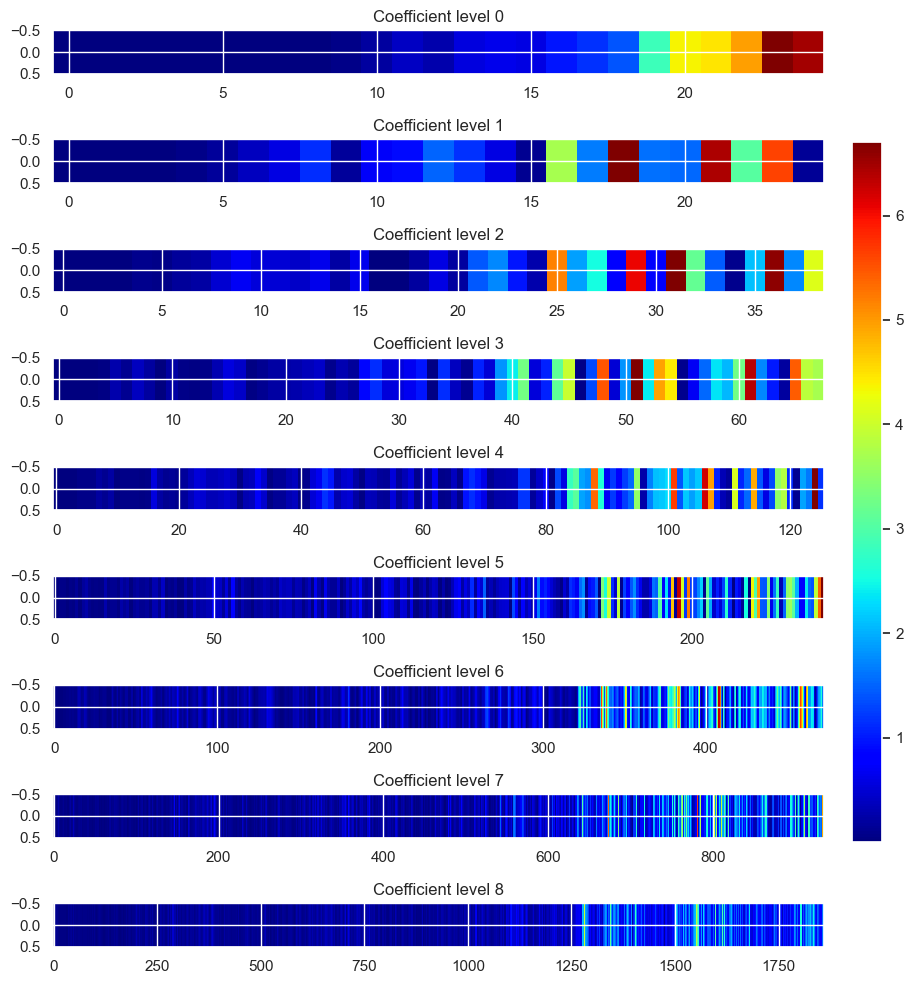

In [54]:
import pywt

# Perform the Discrete Wavelet Transform with 'dbN'
wavelet = pywt.Wavelet('db6')
coeffs = pywt.wavedec(stock_data['Close'], wavelet, level=8)

# Plotting the Wavelet Coefficients using imshow
fig, axes = plt.subplots(len(coeffs), 1, figsize=(10, 10))

for i, ax in enumerate(axes):
    im = ax.imshow(np.abs(coeffs[i].reshape(1, -1)), aspect='auto', cmap='jet')
    ax.set_title(f'Coefficient level {i}')

# Add a single colorbar on the far right
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.show()

# Save the figure
plt.savefig('db6.jpg')

Wavelet db6
  Family name:    Daubechies
  Short name:     db
  Filters length: 12
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


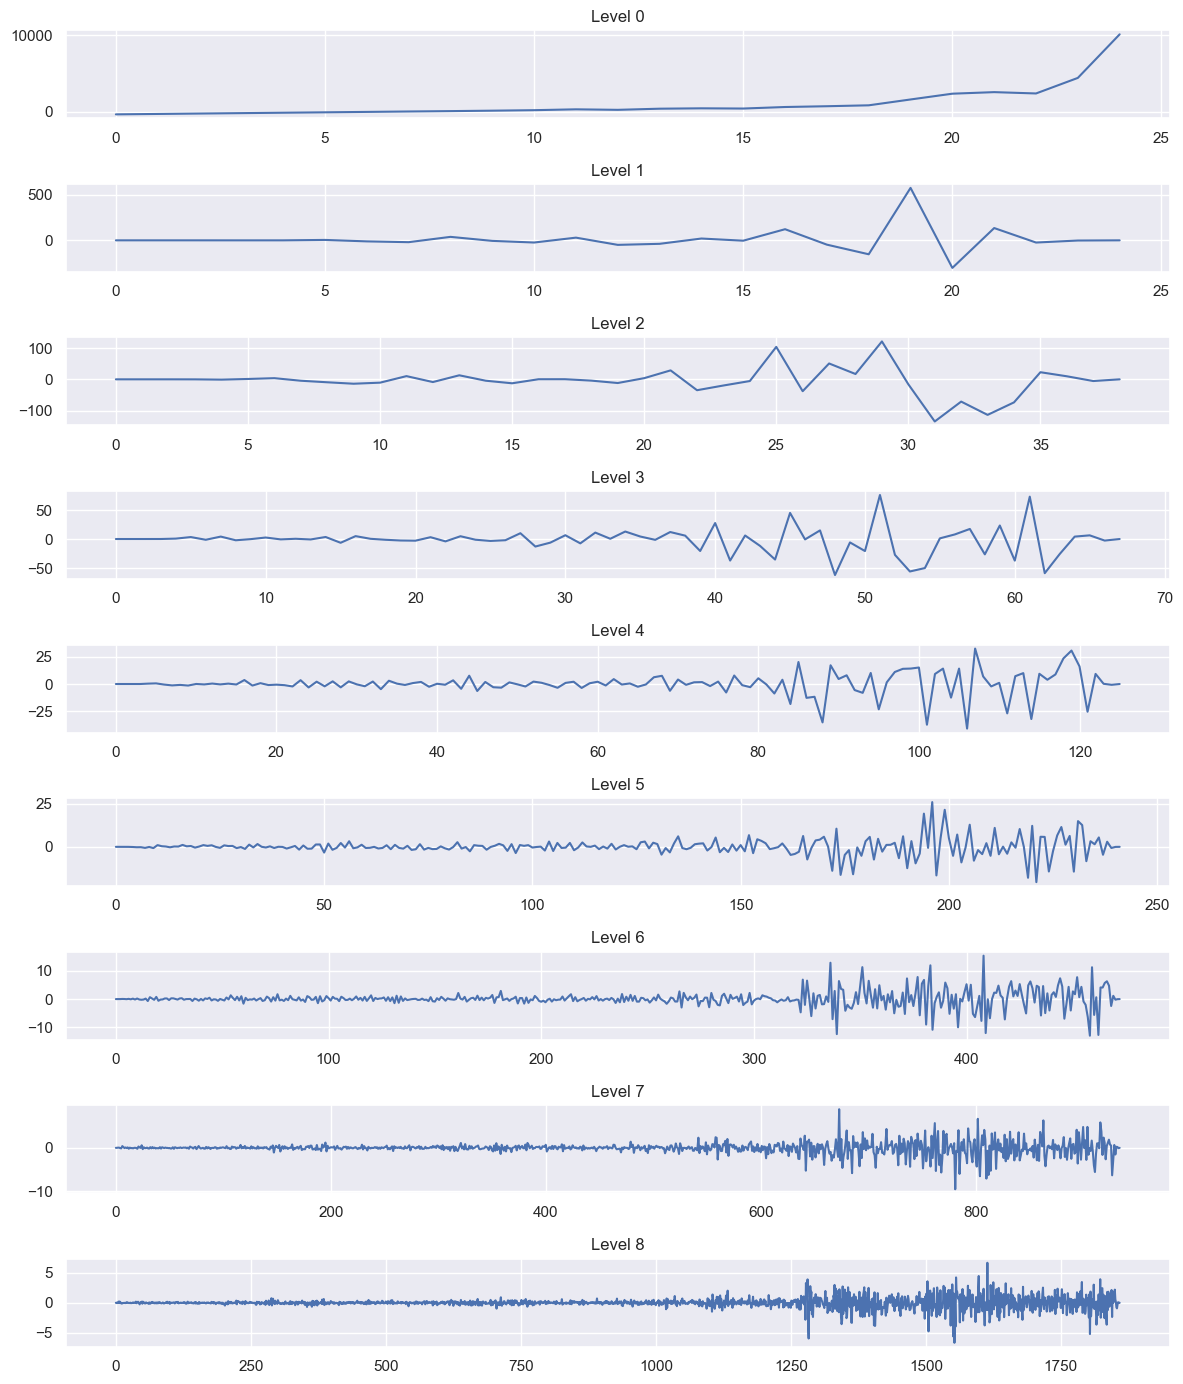

In [47]:
# Wavelet families() : https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#pywt.Wavelet

# Choose Symlets ('symN') of decomposition
wavelet = pywt.Wavelet('db6')
print(wavelet)
level = 8

# Perform wavelet decomposition
# mode – Signal extension mode to deal with signal edge during the transform
# level – Number of decomposition steps to perform
coeffs = pywt.wavedec(stock_data['Close'], wavelet, level=level, mode='smooth')

# Plot the coefficients
plt.figure(figsize=(12, 14))
for i, coeff in enumerate(coeffs):
    plt.subplot(level + 1, 1, i + 1)
    plt.plot(coeff)
    plt.title(f'Level {i}')
plt.tight_layout()
plt.show()

# Define Bi-directional LSTM model

Epoch 1/100
74/74 [==============================] - 9s 41ms/step - loss: 4.9227e-04 - mae: 0.0129 - val_loss: 0.0021 - val_mae: 0.0394
Epoch 2/100
74/74 [==============================] - 1s 20ms/step - loss: 8.2208e-05 - mae: 0.0066 - val_loss: 0.0026 - val_mae: 0.0449
Epoch 3/100
74/74 [==============================] - 2s 22ms/step - loss: 6.1945e-05 - mae: 0.0059 - val_loss: 0.0020 - val_mae: 0.0389
Epoch 4/100
74/74 [==============================] - 2s 21ms/step - loss: 6.6680e-05 - mae: 0.0062 - val_loss: 9.2898e-04 - val_mae: 0.0255
Epoch 5/100
74/74 [==============================] - 2s 21ms/step - loss: 5.1837e-05 - mae: 0.0053 - val_loss: 0.0013 - val_mae: 0.0314
Epoch 6/100
74/74 [==============================] - 1s 20ms/step - loss: 4.4625e-05 - mae: 0.0050 - val_loss: 8.9694e-04 - val_mae: 0.0249
Epoch 7/100
74/74 [==============================] - 1s 18ms/step - loss: 4.2715e-05 - mae: 0.0049 - val_loss: 0.0012 - val_mae: 0.0301
Epoch 8/100
74/74 [=====================

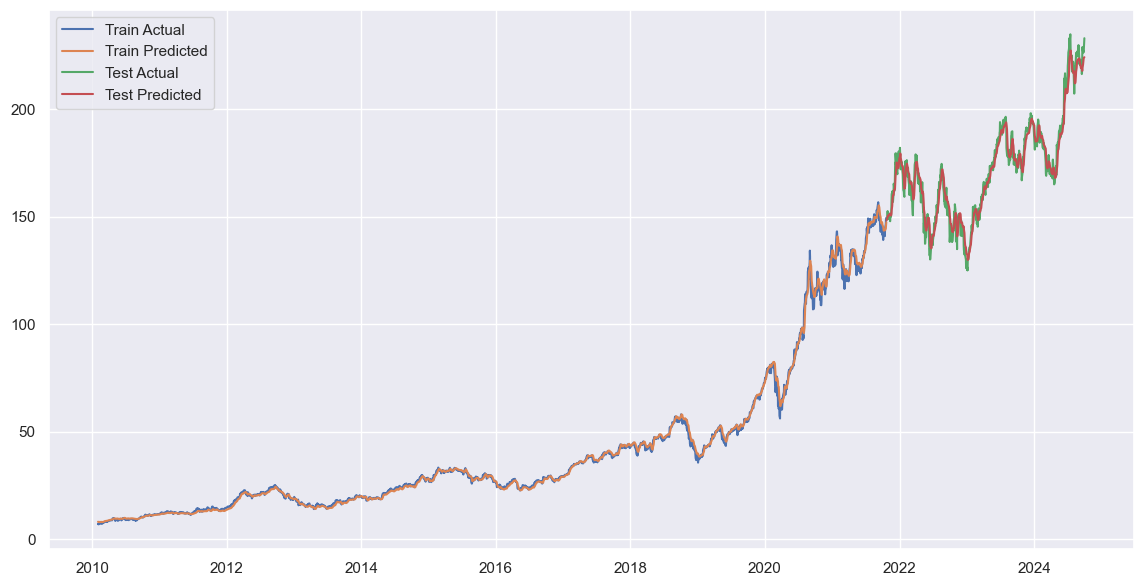

In [43]:
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,  Flatten, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
'''
# Load your stock data
df = stock_data.copy()

wavelet = pywt.Wavelet('db6')

# Apply wavelet transform
def wavelet_transform(data, lvl=8):
    coeff = pywt.wavedec(data, wavelet, mode='symmetric', level=lvl)
    return coeff

# Inverse wavelet transform
def inverse_wavelet_transform(coeff):
    # remove last 3 finer details
    for i in range(3):
        coeffs[i+5] = np.zeros(coeffs[i+5].shape)
    return pywt.waverec(coeff, wavelet, mode='symmetric')

# Prepare data
close_prices = df['Close'].values
wavelet_coeff = wavelet_transform(close_prices)
reconstructed_data = inverse_wavelet_transform(wavelet_coeff)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(reconstructed_data.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential([
    Bidirectional(LSTM(units=256, return_sequences=True, input_shape=(seq_length, 1))),
    Dropout(0.3), 
    Bidirectional(LSTM(units=128, return_sequences=False)),
    Dropout(0.3), 
    RepeatVector(seq_length),  # Number of future timesteps
    #Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2), 
    Dense(units=64, activation='relu'),
    Dense(units=32),
    # Flatten layer to transition to Dense layer
    Flatten(),
    Dense(units=1)
          ])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate error metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

#print(f"Train MAE: {train_mae}, Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train MAPE: {train_mape}, Train R2: {train_r2}")
#print(f"Test MAE: {test_mae}, Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test MAPE: {test_mape}, Test R2: {test_r2}")

metric_data = {
    "Metric": ["MAE", "MSE", "RMSE", "MAPE", "R2"],
    "Train": [train_mae, train_mse, train_rmse, train_mape, train_r2],
    "Test": [test_mae, test_mse, test_rmse, test_mape, test_r2]
}

# Convert to dataframe
metric_df = pd.DataFrame(metric_data)

print(metric_df)

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[seq_length:split + seq_length], y_train, label='Train Actual')
plt.plot(df.index[seq_length:split + seq_length], train_predictions, label='Train Predicted')
plt.plot(df.index[split + seq_length:], y_test, label='Test Actual')
plt.plot(df.index[split + seq_length:], test_predictions, label='Test Predicted')
plt.legend()
#plt.show()

# Save the figure
plt.savefig('LSTM.jpg')

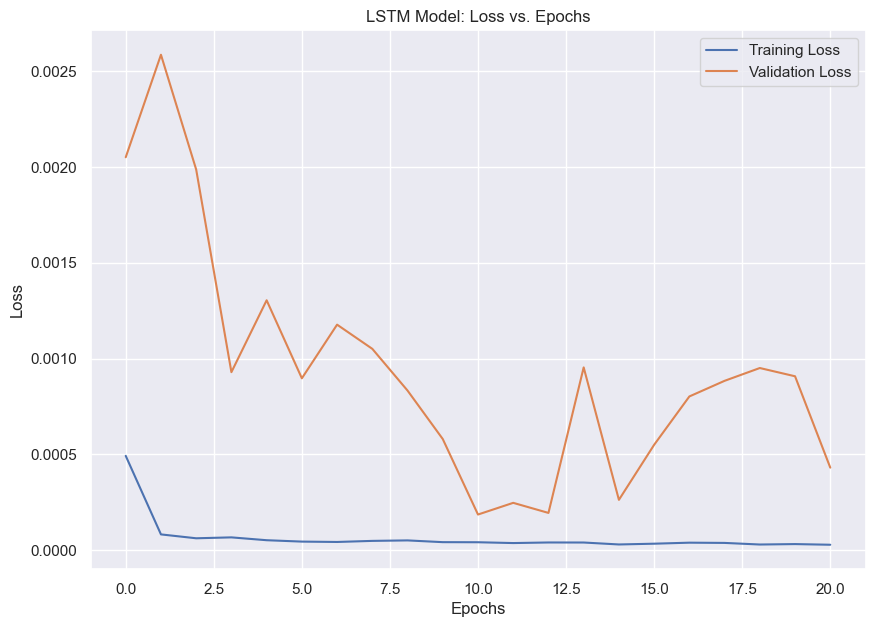

In [48]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
# If you have validation loss, you can plot it as well
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model: Loss vs. Epochs')
plt.legend()

#plt.show()

# Save the figure
plt.savefig('LossEpoch.jpg')

In [49]:
import pandas as pd
df_index = pd.DataFrame(stock_data['Close'].iloc[-y_test.shape[0]:].copy()).index
# Suppose y_test and predict_value are NumPy arrays
y_test_df = pd.DataFrame(y_test, columns=['y_test'], index=df_index )
predict_value_df = pd.DataFrame(test_predictions, columns=['predict_value'], index=df_index)

# Concatenate along the columns
combined_df = pd.concat([y_test_df, predict_value_df], axis=1)
combined_df

y_test  predict_value
Date                                 
2021-10-22  148.690002     148.353271
2021-10-25  148.639999     148.886337
2021-10-26  149.320007     149.248688
2021-10-27  148.850006     149.599777
2021-10-28  152.570007     149.693863
...                ...            ...
2024-09-24  227.369995     221.897690
2024-09-25  226.369995     222.887756
2024-09-26  227.520004     223.439697
2024-09-27  227.789993     223.923752
2024-09-30  233.000000     224.157974

[738 rows x 2 columns]

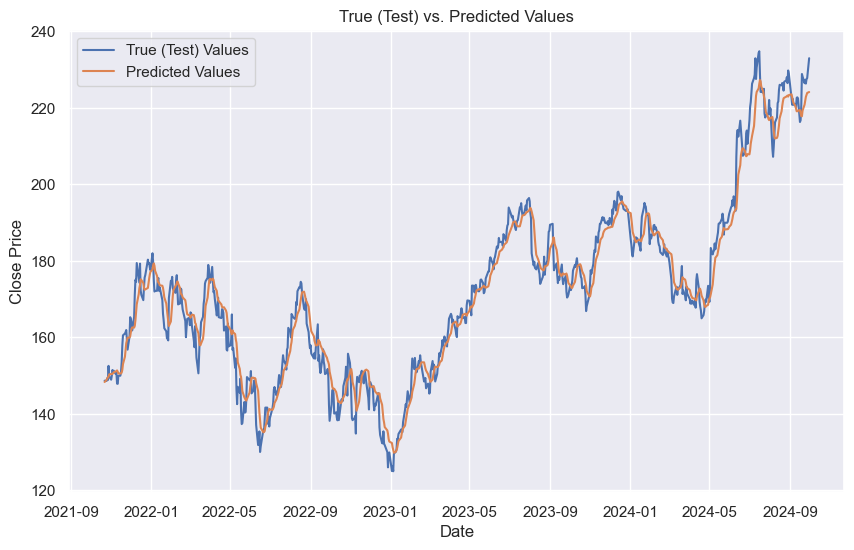

In [50]:
# Plotting true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index, combined_df['y_test'], label='True (Test) Values')
plt.plot(combined_df.index, combined_df['predict_value'], label='Predicted Values')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('True (Test) vs. Predicted Values')
plt.legend()
#plt.show()

# Save the figure
plt.savefig('LSTM2.jpg')

In [51]:
X_test.shape

(738, 20, 1)

In [52]:

input_seq = X_test[-seq_length:]  # Use same window size as used in training
#print(input_seq.shape)

next_n_days_predictions = []

# Forecast for the next n days
forecast_horizon = 10


for _ in range(forecast_horizon):
     # Reshape the input to match the model's expected input shape
    input_seq = input_seq.reshape((1, -seq_length, 1))  # Shape should be (1, window_size, 1)

    # Predict the next value
    predicted_value = model.predict(input_seq)

    # Append prediction to results
    next_n_days_predictions.append(predicted_value[0, 0])
    
    # Update the input window with the new prediction
    #input_seq = np.append(input_seq, predicted_value)
    # Update the historical_data sequence by removing the oldest value and adding the predicted value
    input_seq = np.roll(input_seq, shift=-1)
    input_seq[-1] = predicted_value

next_n_days_predictions = scaler.inverse_transform(np.array(next_n_days_predictions).reshape(-1, 1))


1/1 [==============================] - 0s 64ms/step


In [55]:
# Create a datetime index for predictions
last_date = df.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')
predictions_df = pd.DataFrame(next_n_days_predictions, columns=['Predictions'], index=prediction_dates)
predictions_df

Predictions
2024-10-01   225.325867
2024-10-02   224.685196
2024-10-03   224.081543
2024-10-04   223.517654
2024-10-07   222.991913
2024-10-08   222.502533
2024-10-09   222.037552
2024-10-10   221.607834
2024-10-11   221.205963
2024-10-14   220.832474